In [1]:
import copy
import os
import pathlib
import pandas as pd
import numpy as np
import re
import json
from utils import summarize_results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Extract data from the Prescient/Double-loop output files

In [2]:
# summarize the data in different LMP zones

def summarize_lmp_dispatch(result_dir, generator_name):
    df = pd.read_csv(result_dir)
    
    # cap RT lmp to 500.
    lmp_array = df["LMP"].to_numpy()
    df["LMP"] = pd.DataFrame(np.clip(lmp_array, 0, 500))
    
    # filter dispatch result
    res_dict = {}
    res_dict['zone_0_5'] = []
    res_dict['zone_5_10'] = []
    res_dict['zone_10_15'] = []
    res_dict['zone_15_20'] = []
    res_dict['zone_20_25'] = []
    res_dict['zone_25_30'] = []
    res_dict['zone_30_35'] = []
    res_dict['zone_35_40'] = []
    res_dict['zone_40_500'] = []
    
    for i in range(len(df)):
        LMP = df.iloc[i]['LMP']
        dispatch = df.iloc[i][f'{generator_name} Dispatch']
        if LMP <= 5:
            res_dict['zone_0_5'].append(dispatch)
        elif 5 < LMP <= 10:
            res_dict['zone_5_10'].append(dispatch)
        elif 10 < LMP <= 15:
            res_dict['zone_10_15'].append(dispatch)
        elif 15 < LMP <= 20:
            res_dict['zone_15_20'].append(dispatch)
        elif 20 < LMP <= 25:
            res_dict['zone_20_25'].append(dispatch)
        elif 25 < LMP <= 30:
            res_dict['zone_25_30'].append(dispatch)
        elif 30 < LMP <= 35:
            res_dict['zone_30_35'].append(dispatch)
        elif 35 < LMP <= 40:
            res_dict['zone_35_40'].append(dispatch)
        elif 40 < LMP:
            res_dict['zone_40_500'].append(dispatch)
    
    return res_dict, df

In [3]:
# get the simulation results

generator_name = '303_WIND_1'
# wo_cb = wind only constant bidding
res_dict_wo_cb, df_wo_cb = summarize_lmp_dispatch(f'Benchmark_wind_only_prescient_lmp_dispatch_results/Benchmark_wind_gen_prescient_2024_{generator_name}.csv', generator_name)

# wo_sb = wind only stochastic bidding
res_dict_wo_sb, df_wo_sb = summarize_lmp_dispatch(f'Benchmark_wind_only_sb_lmp_dispatch_results/Benchmark_wind_only_sb_{generator_name}.csv', generator_name)

# wb_sb = wind battery stochastic bidding
res_dict_wb_sb_s, df_wb_sb_s = summarize_lmp_dispatch(f'wind_battery_duration_sb_hour2_ratio_01_lmp_dispatch_results/wind_battery_duration_sb_hour2_ratio_01_{generator_name}.csv', generator_name)

# wb_sb = wind battery stochastic bidding
res_dict_wb_sb_l, df_wb_sb_l = summarize_lmp_dispatch(f'wind_battery_duration_sb_hour10_ratio_10_lmp_dispatch_results/wind_battery_duration_sb_hour10_ratio_10_{generator_name}.csv', generator_name)

### Make LMP csv for the wind only + time invariant case

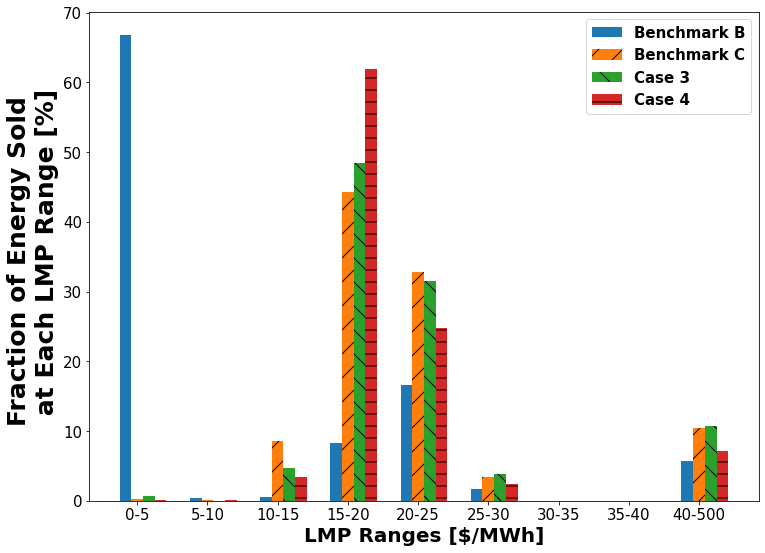

In [10]:
font1 = {'weight' : 'bold', 'size': 20}
sum_list_wo_cb = []
sum_list_wo_sb = []
sum_list_wb_sb_s = []
sum_list_wb_sb_l = []

# sum of output at each zone
for i in res_dict_wo_cb.keys():
    sum_list_wo_cb.append(sum(res_dict_wo_cb[i]))
for i in res_dict_wo_sb.keys():
    sum_list_wo_sb.append(sum(res_dict_wo_sb[i]))
for i in res_dict_wb_sb_s.keys():
    sum_list_wb_sb_s.append(sum(res_dict_wb_sb_s[i]))
for i in res_dict_wb_sb_l.keys():
    sum_list_wb_sb_l.append(sum(res_dict_wb_sb_l[i]))

# scale to 0-1
total_dispatch_wo_cb = sum(sum_list_wo_cb)
total_dispatch_wo_sb = sum(sum_list_wo_sb)
total_dispatch_wb_sb_s = sum(sum_list_wb_sb_s)
total_dispatch_wb_sb_l = sum(sum_list_wb_sb_l)


# for ratio plots
sum_list_scaled_wo_cb = []
sum_list_scaled_wo_sb = []
sum_list_scaled_wb_sb_s = []
sum_list_scaled_wb_sb_l = []

for i in sum_list_wo_cb:
    sum_list_scaled_wo_cb.append(i/total_dispatch_wo_cb*100)
for i in sum_list_wo_sb:
    sum_list_scaled_wo_sb.append(i/total_dispatch_wo_sb*100)
for i in sum_list_wb_sb_s:
    sum_list_scaled_wb_sb_s.append(i/total_dispatch_wb_sb_s*100)
for i in sum_list_wb_sb_l:
    sum_list_scaled_wb_sb_l.append(i/total_dispatch_wb_sb_l*100)  


# plot bar plot
xrange = ['0-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-500']
x = np.arange(len(xrange))*3
plt.figure(figsize=(12, 9))


# for ratio
plt.bar(x-0.5, sum_list_scaled_wo_cb, width = 0.5, label = 'Benchmark B')
plt.bar(x, sum_list_scaled_wo_sb, width = 0.5, hatch = '/', label = 'Benchmark C')
plt.bar(x+0.5, sum_list_scaled_wb_sb_s, width = 0.5, hatch = '\\', label = 'Case 3')
plt.bar(x+1.0, sum_list_scaled_wb_sb_l, width = 0.5, hatch = '-', label = 'Case 4')
plt.ylabel('Fraction of Energy Sold \n at Each LMP Range [%]', font = {'weight': 'bold', 'size': 25})

plt.xticks(ticks = x, labels = xrange, font = {"size": 15})
plt.yticks(font = {"size": 15})
plt.legend(prop = { "size": 15 , 'weight': 'bold'})
plt.xlabel('LMP Ranges [$/MWh]', font = { "size": 20 , 'weight': 'bold'})
# plt.title('303_WIND_1', font = font1)
plt.show()

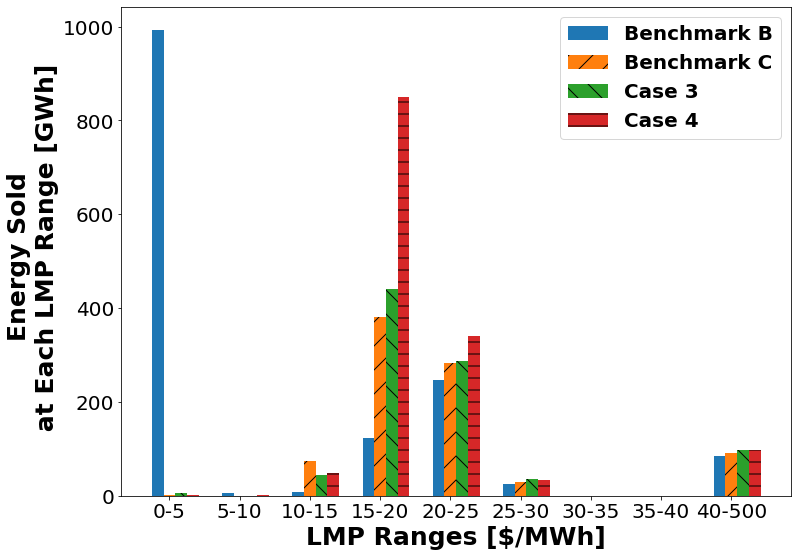

In [9]:
# for absolute amount
xrange = ['0-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-500']
x = np.arange(len(xrange))*3
plt.figure(figsize=(12, 9))

plt.bar(x-0.5, np.array(sum_list_wo_cb)/1000, width = 0.5, label = 'Benchmark B')
plt.bar(x, np.array(sum_list_wo_sb)/1000, width = 0.5, hatch = '/', label = 'Benchmark C')
plt.bar(x+0.5, np.array(sum_list_wb_sb_s)/1000, width = 0.5, hatch = '\\', label = 'Case 3')
plt.bar(x+1.0, np.array(sum_list_wb_sb_l)/1000, width = 0.5, hatch = '-', label = 'Case 4')
plt.ylabel('Energy Sold \n at Each LMP Range [GWh]', font = { "size": 25 , 'weight': 'bold'})

plt.xticks(ticks = x, labels = xrange, font = {"size": 20})
plt.yticks(font = {"size": 20})
plt.legend(prop = { "size": 20 , 'weight': 'bold'})
plt.xlabel('LMP Ranges [$/MWh]', font = { "size": 25 , 'weight': 'bold'})
# plt.title('303_WIND_1', font = font1)
plt.show()

In [11]:
# calculate average LMP that generator received.
rev_wo_cb = 0
for i in range(len(df_wo_cb)):
    rev_wo_cb += df_wo_cb.iloc[i]['LMP']*df_wo_cb.iloc[i]['303_WIND_1 Dispatch']

rev_wo_sb = 0
for i in range(len(df_wo_sb)):
    rev_wo_sb += df_wo_sb.iloc[i]['LMP']*df_wo_sb.iloc[i]['303_WIND_1 Dispatch']
    
rev_wb_sb_s = 0
for i in range(len(df_wb_sb_s)):
    rev_wb_sb_s += df_wb_sb_s.iloc[i]['LMP']*df_wb_sb_s.iloc[i]['303_WIND_1 Dispatch']
    
rev_wb_sb_l = 0
for i in range(len(df_wb_sb_l)):
    rev_wb_sb_l += df_wb_sb_l.iloc[i]['LMP']*df_wb_sb_l.iloc[i]['303_WIND_1 Dispatch']
    
avg_lmp_wo_cb = rev_wo_cb/total_dispatch_wo_cb
avg_lmp_wo_sb = rev_wo_sb/total_dispatch_wo_sb
avg_lmp_wb_sb_s = rev_wb_sb_s/total_dispatch_wb_sb_s
avg_lmp_wb_sb_l = rev_wb_sb_l/total_dispatch_wb_sb_l

print('Average LMP that generator received.')
print('Wind only, TI bids, ', avg_lmp_wo_cb, '$/MWh')
print('Wind only, TV bids, ', avg_lmp_wo_sb, '$/MWh')
print('Wind+small battery, ', avg_lmp_wb_sb_s, '$/MWh')
print('Wind+large battery, ', avg_lmp_wb_sb_l, '$/MWh')

Average LMP that generator received.
Wind only, TI bids,  12.80522309973492 $/MWh
Wind only, TV bids,  27.393302080421886 $/MWh
Wind+small battery,  27.91150636042045 $/MWh
Wind+large battery,  26.232414005267934 $/MWh


In [12]:
# calculate the mean LMP

print('Mean LMP at the bus')
print('Wind only, TI bids, ', df_wo_cb['LMP'].mean(), '$/MWh')
print('Wind only, TV bids, ', df_wo_sb['LMP'].mean(), '$/MWh')
print('Wind+small battery, ', df_wb_sb_s['LMP'].mean(), '$/MWh')
print('Wind+large battery, ', df_wb_sb_l['LMP'].mean(), '$/MWh')

Mean LMP at the bus
Wind only, TI bids,  24.5608032371357 $/MWh
Wind only, TV bids,  24.55500447518215 $/MWh
Wind+small battery,  25.30260035883424 $/MWh
Wind+large battery,  24.999983467554646 $/MWh


## Example plots for bids and lmps

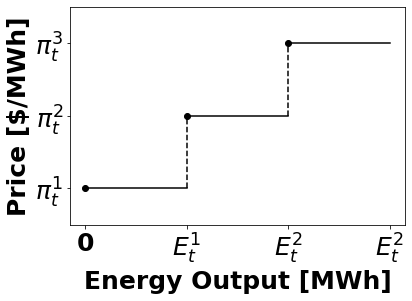

In [16]:
# Example plot for the bids

plt.figure(figsize=(6,4))
font1 = {'weight' : 'bold',
        'size'   : 25,
        } 

plt.yticks(np.arange(4), (' ',r'$\pi^{1}_{t}$' , r'$\pi^2_{t}$', r'$\pi^{3}_{t}$'), font = font1)
plt.xticks(np.arange(5), ('', '0', r'$E^1_{t}$', r'$E^2_{t}$', r'$E^2_{t}$'), font = font1)

x = np.array([1,2])
y = np.array([1,1])
plt.scatter(1,1, c = 'k')
plt.plot(x,y,'-', c = 'k')

x1 = np.array([2,3])
y1 = np.array([2,2])
plt.plot(x1,y1,'-', c = 'k')
plt.scatter(2,2, c = 'k')

plt.plot([2,2],[1,2], '--',c = 'k')

x1 = np.array([3,4])
y1 = np.array([3,3])
plt.plot(x1,y1,'-', c = 'k')
plt.scatter(3,3, c = 'k')

plt.plot([3,3],[2,3], '--',c = 'k')

# plt.xlim(0.5,3.5)
plt.ylim(0.5,3.5)
plt.xlabel('Energy Output [MWh]', font=font1)
plt.ylabel('Price [$/MWh]', font=font1)
plt.show()

<Figure size 432x288 with 0 Axes>

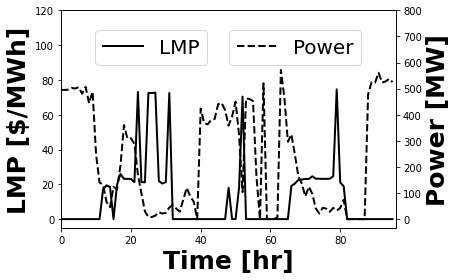

In [17]:
# Example plot of LMP vs dispatch

wo_cb_lmp_ts = df_wo_cb['LMP'].to_numpy()[0:96]
wo_cb_dispatch_ts = df_wo_cb['303_WIND_1 Dispatch'].to_numpy()[0:96]
plt.figure(figsize=(6,4))
fig, ax1 = plt.subplots()
ax1.plot(wo_cb_lmp_ts, c = 'k', linewidth = 2, label = 'LMP')
ax1.set_ylim(-5, 120)
ax1.set_xlim(0, 96)
# ax1.set_xticks(ticks = range(len(wo_cb_lmp_ts), 12), font = {"size": 25})
# ax1.set_yticks(ticks = 'y', font = {"size": 25})
ax1.set_xlabel('Time [hr]', font = {"size": 25, 'weight': 'bold'})
ax1.set_ylabel('LMP [$/MWh]', font = {"size": 25, 'weight': 'bold'})
ax2 = ax1.twinx()
ax2.plot(wo_cb_dispatch_ts, c = 'k', linewidth = 2, linestyle = '--', label = 'Power')
ax2.set_ylabel('Power [MW]', font = {"size": 25, 'weight': 'bold'})
ax2.set_ylim(-33.3, 800)
# plt.title('Example LMP Signals', font = {"size": 25, 'weight': 'bold'})
ax1.legend(loc = (0.1, 0.75), fontsize = 20)
ax2.legend(loc = (0.5, 0.75), fontsize = 20)
# plt.legend()
plt.show()

## LMP histograms

In [13]:
# some data in Table 2

len(df_wo_cb[df_wo_cb['LMP'] >= 100].dropna()['LMP']) # 170
len(df_wo_cb[df_wo_sb['LMP'] >= 100].dropna()['LMP']) # 105
len(df_wo_cb[df_wb_sb_s['LMP'] >= 100].dropna()['LMP']) # 118
len(df_wo_cb[df_wb_sb_l['LMP'] >= 100].dropna()['LMP']) # 114

df_wo_cb[df_wo_cb['LMP'] <= 100].dropna()['LMP'].mean() # 17.77
df_wo_cb[df_wo_sb['LMP'] <= 100].dropna()['LMP'].mean() # 20.04
df_wo_cb[df_wb_sb_s['LMP'] <= 100].dropna()['LMP'].mean() # 19.71
df_wo_cb[df_wb_sb_l['LMP'] <= 100].dropna()['LMP'].mean() # 21.85

21.857007621337946

In [18]:
def plot_hist_in_one_plot(data1, data2):
    bins = [i for i in range(0, 105, 5)] + [500]
    _ticks = [0, 20, 40, 60, 40, 80, 100, 120]
    _tick_label = [str(i) for i in [0, 20, 40, 60, 40, 80, 100]] + ["500"]
    
    font1 = {'size': 25, 'weight': 'bold'}
    
    plt.figure(figsize = (12, 9))
    plt.rcParams.update({'font.size': 20})
    # plt.hist(data, bins=bins, weights = [np.ones(len(pt_data)) / len(pt_data), np.ones(len(dl_data)) / len(dl_data)], stacked = True)
    pt = plt.hist(data1, bins=bins, weights=np.ones(len(data1)) / len(data1), label = "Case 1")
    dl = plt.hist(data2, hatch = '\\', bins=bins, fill=False, weights=np.ones(len(data2)) / len(data2), label = "Case 3")

    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.xlabel("LMP [$/MWh]", font = font1)
    plt.ylabel("Frequency [%]", font = font1)
    plt.xlim([0, 120])
    plt.ylim([0, 0.5])
    plt.xticks(ticks=_ticks, labels=_tick_label)
    plt.tick_params(direction='in', top=True, right=True, labelsize = 20)
#     plt.text(30, 0.25, f'PT Average = {np.round(np.mean(pt_data),2)} $/MWh', font=font1)
#     plt.text(30, 0.15, f'MS Average = {np.round(np.mean(dl_data),2)} $/MWh', font=font1)
#     plt.title("Annual LMP Histogram at Bus Caesar", font=font1)
    plt.legend(prop = {'size': 20, 'weight': 'bold'})
    plt.show()
    
    return pt, dl

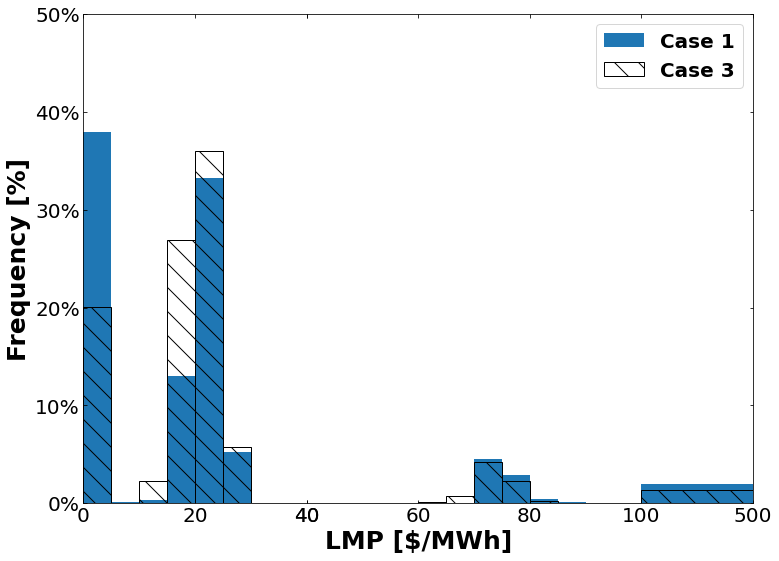

In [20]:
plot_hist_in_one_plot(df_wo_cb['LMP'].to_numpy(), df_wb_sb_s['LMP'].to_numpy())
plt.show()

## Price-taker wind only/small battery/large battery

### wind only

In [21]:
with open('hourly_result_RT_wind_847_battery_0.0_hour_0.json', 'rb') as f:
    res = json.load(f)
res.keys()
wind_cfs = pd.read_csv('303_Wind_Dispatch.csv')['303_WIND_1-RTCF'].values 

In [23]:
lmp_df = pd.read_csv('303_LMPs_15_reserve_500_shortfall.csv')
lmp = lmp_df['LMP'].to_numpy()
high_lmp_dispacth = []
if len(lmp) == len(wind_cfs):
    for i, j in enumerate(lmp):
        if j >= 100:
            high_lmp_dispacth.append(wind_cfs[i]*847)
print('Total hours that LMP is over $100/MWh:', len(high_lmp_dispacth))
print('Total power dispatched over $100/MWh:', sum(high_lmp_dispacth))

Total hours that LMP is over $100/MWh: 170
Total power dispatched over $100/MWh: 13784.499994880995


### wind + small battery

In [24]:
with open('hourly_result_RT_wind_847_battery_0.1_hour_2.json', 'rb') as f:
    res = json.load(f)
res.keys()

dict_keys(['soc', 'wind_gen', 'batt_to_grid', 'wind_to_grid', 'wind_to_batt', 'total_elec_output', 'elec_revenue', 'annual_revenue', 'npv'])

In [25]:
# calculate the curtailment
energy_lost = 0
energy_through = 0
for i, j in zip(res['wind_to_batt'],res['batt_to_grid']):
    energy_lost += i - j
    energy_through += (i + j)
energy_lost, energy_through
energy_through*1e-4/2

7.02172438711753

In [26]:
lmp_df = pd.read_csv('303_LMPs_15_reserve_500_shortfall.csv')
lmp = lmp_df['LMP'].to_numpy()
high_lmp_dispacth = []
if len(lmp) == len(wind_cfs):
    for i, j in enumerate(lmp):
        if j >= 100:
            high_lmp_dispacth.append(res['wind_to_grid'][i] + res['batt_to_grid'][i])
print('Total hours that LMP is over $100/MWh:', len(high_lmp_dispacth))
print('Total power dispatched over $100/MWh:', sum(high_lmp_dispacth))

Total hours that LMP is over $100/MWh: 170
Total power dispatched over $100/MWh: 21384.287746182406


In [29]:
soc_pt = np.array(res['soc'])/1000
path = 'wind_battery_duration_sb_hour2_ratio_01_lmp_dispatch_results/tracking_model_detail.csv'
df = pd.read_csv(path)
df_soc = df.filter(items = ['Horizon [hr]', 'State of Charge [MWh]'])
soc_dl = []
for i in range(0, len(df_soc), 10):
    soc_dl.append(df_soc['State of Charge [MWh]'][i])
    if df_soc['Horizon [hr]'][i] != 0:
        raise('Error in horizon')
lmp_path = 'wind_battery_duration_sb_hour2_ratio_01_lmp_dispatch_results/wind_battery_duration_sb_hour2_ratio_01_303_WIND_1.csv'
lmp_dl_array = pd.read_csv(lmp_path)['LMP'].to_numpy()
# compare_soc(soc_dl, soc_pt, lmp, lmp_dl_array, 440,464)

### wind + large battery

In [30]:
with open('hourly_result_RT_wind_847_battery_1.0_hour_10.json', 'rb') as f:
    res = json.load(f)
res.keys()

dict_keys(['soc', 'wind_gen', 'batt_to_grid', 'wind_to_grid', 'wind_to_batt', 'total_elec_output', 'elec_revenue', 'annual_revenue', 'npv'])

In [31]:
# calculate the curtailment
energy_lost = 0
energy_through = 0
for i, j in zip(res['wind_to_batt'],res['batt_to_grid']):
    energy_lost += i - j
    energy_through += i + j
energy_lost, energy_through*1e-4

(99503.02784031049, 194.15847227301484)

In [32]:
t = 1
er = []
td = []
for i,j,k,l,m,n in zip(lmp, res['wind_gen'], res['wind_to_grid'], res['wind_to_batt'], res['batt_to_grid'], res['soc']):
    print(f't={t}', f'total dispatch: {k+m:.2f}', f'lmp: {i:.2f}', f'wind gen: {j:.2f}', f'wind to grid: {k:.2f}', f'wind to batt: {l:.2f}', f'batt to grid: {m:.2f}', f'soc: {n/1000:.2f}')
    t+=1
#     total_dis = k + m
#     elec_rev = total_dis*i
#     td.append(total_dis)
#     er.append(elec_rev)
# np.sum(er)/np.sum(td)

t=1 total dispatch: 0.00 lmp: 0.00 wind gen: 826.20 wind to grid: 0.00 wind to batt: 826.20 batt to grid: 0.00 soc: 784.89
t=2 total dispatch: 0.00 lmp: 0.00 wind gen: 819.20 wind to grid: 0.00 wind to batt: 819.20 batt to grid: 0.00 soc: 1563.13
t=3 total dispatch: 0.00 lmp: 0.00 wind gen: 775.40 wind to grid: 0.00 wind to batt: 775.40 batt to grid: 0.00 soc: 2299.76
t=4 total dispatch: 0.00 lmp: 0.00 wind gen: 749.50 wind to grid: 0.00 wind to batt: 749.50 batt to grid: 0.00 soc: 3011.79
t=5 total dispatch: 0.00 lmp: 0.00 wind gen: 802.10 wind to grid: 0.00 wind to batt: 802.10 batt to grid: 0.00 soc: 3773.78
t=6 total dispatch: 0.00 lmp: 0.00 wind gen: 819.50 wind to grid: 0.00 wind to batt: 819.50 batt to grid: 0.00 soc: 4552.31
t=7 total dispatch: 0.00 lmp: 0.00 wind gen: 794.80 wind to grid: 0.00 wind to batt: 794.80 batt to grid: 0.00 soc: 5307.37
t=8 total dispatch: 0.00 lmp: 0.00 wind gen: 761.90 wind to grid: 0.00 wind to batt: 761.90 batt to grid: 0.00 soc: 6031.17
t=9 total

t=277 total dispatch: 1.20 lmp: 0.00 wind gen: 108.58 wind to grid: 1.20 wind to batt: 107.39 batt to grid: 0.00 soc: 7869.71
t=278 total dispatch: 1.17 lmp: 0.00 wind gen: 114.88 wind to grid: 1.17 wind to batt: 113.71 batt to grid: 0.00 soc: 7977.74
t=279 total dispatch: 1.15 lmp: 0.00 wind gen: 160.38 wind to grid: 1.15 wind to batt: 159.23 batt to grid: 0.00 soc: 8129.01
t=280 total dispatch: 1.13 lmp: 0.00 wind gen: 222.88 wind to grid: 1.13 wind to batt: 221.76 batt to grid: 0.00 soc: 8339.69
t=281 total dispatch: 1.09 lmp: 0.00 wind gen: 133.98 wind to grid: 1.09 wind to batt: 132.90 batt to grid: 0.00 soc: 8465.94
t=282 total dispatch: 931.60 lmp: 21.29 wind gen: 84.60 wind to grid: 84.60 wind to batt: 0.00 batt to grid: 847.00 soc: 7574.36
t=283 total dispatch: 904.20 lmp: 76.43 wind gen: 57.20 wind to grid: 57.20 wind to batt: 0.00 batt to grid: 847.00 soc: 6682.78
t=284 total dispatch: 884.00 lmp: 80.28 wind gen: 37.00 wind to grid: 37.00 wind to batt: 0.00 batt to grid: 847

t=527 total dispatch: 651.53 lmp: 0.00 wind gen: 668.38 wind to grid: 651.53 wind to batt: 16.85 batt to grid: 0.00 soc: 43.47
t=528 total dispatch: 585.97 lmp: 0.00 wind gen: 599.98 wind to grid: 585.97 wind to batt: 14.01 batt to grid: 0.00 soc: 56.78
t=529 total dispatch: 760.96 lmp: 0.00 wind gen: 773.78 wind to grid: 760.96 wind to batt: 12.82 batt to grid: 0.00 soc: 68.96
t=530 total dispatch: 807.06 lmp: 0.00 wind gen: 819.28 wind to grid: 807.06 wind to batt: 12.23 batt to grid: 0.00 soc: 80.58
t=531 total dispatch: 812.22 lmp: 0.00 wind gen: 824.18 wind to grid: 812.22 wind to batt: 11.96 batt to grid: 0.00 soc: 91.94
t=532 total dispatch: 820.57 lmp: 0.00 wind gen: 832.48 wind to grid: 820.57 wind to batt: 11.92 batt to grid: 0.00 soc: 103.26
t=533 total dispatch: 820.45 lmp: 0.00 wind gen: 832.48 wind to grid: 820.45 wind to batt: 12.04 batt to grid: 0.00 soc: 114.70
t=534 total dispatch: 817.49 lmp: 0.00 wind gen: 829.78 wind to grid: 817.49 wind to batt: 12.30 batt to grid

t=746 total dispatch: 793.72 lmp: 0.00 wind gen: 821.78 wind to grid: 793.72 wind to batt: 28.06 batt to grid: 0.00 soc: 182.23
t=747 total dispatch: 782.91 lmp: 0.00 wind gen: 815.48 wind to grid: 782.91 wind to batt: 32.57 batt to grid: 0.00 soc: 213.18
t=748 total dispatch: 760.87 lmp: 0.00 wind gen: 800.88 wind to grid: 760.87 wind to batt: 40.02 batt to grid: 0.00 soc: 251.19
t=749 total dispatch: 776.40 lmp: 0.00 wind gen: 830.28 wind to grid: 776.40 wind to batt: 53.88 batt to grid: 0.00 soc: 302.38
t=750 total dispatch: 752.14 lmp: 0.00 wind gen: 838.68 wind to grid: 752.14 wind to batt: 86.54 batt to grid: 0.00 soc: 384.60
t=751 total dispatch: 598.65 lmp: 0.00 wind gen: 832.68 wind to grid: 598.65 wind to batt: 234.04 batt to grid: 0.00 soc: 606.93
t=752 total dispatch: 133.40 lmp: 0.00 wind gen: 828.78 wind to grid: 133.40 wind to batt: 695.38 batt to grid: 0.00 soc: 1267.54
t=753 total dispatch: 54.09 lmp: 0.00 wind gen: 824.58 wind to grid: 54.09 wind to batt: 770.50 batt 

t=974 total dispatch: 0.00 lmp: 0.00 wind gen: 5.10 wind to grid: 0.00 wind to batt: 5.10 batt to grid: 0.00 soc: 8014.90
t=975 total dispatch: 0.00 lmp: 0.00 wind gen: 5.70 wind to grid: 0.00 wind to batt: 5.70 batt to grid: 0.00 soc: 8020.32
t=976 total dispatch: 0.00 lmp: 19.43 wind gen: 4.10 wind to grid: 0.00 wind to batt: 4.10 batt to grid: 0.00 soc: 8024.21
t=977 total dispatch: 4.80 lmp: 71.65 wind gen: 4.80 wind to grid: 4.80 wind to batt: 0.00 batt to grid: 0.00 soc: 8024.21
t=978 total dispatch: 853.40 lmp: 500.00 wind gen: 6.40 wind to grid: 6.40 wind to batt: 0.00 batt to grid: 847.00 soc: 7132.63
t=979 total dispatch: 856.80 lmp: 500.00 wind gen: 9.80 wind to grid: 9.80 wind to batt: 0.00 batt to grid: 847.00 soc: 6241.05
t=980 total dispatch: 856.80 lmp: 500.00 wind gen: 9.80 wind to grid: 9.80 wind to batt: 0.00 batt to grid: 847.00 soc: 5349.47
t=981 total dispatch: 855.00 lmp: 500.00 wind gen: 8.00 wind to grid: 8.00 wind to batt: 0.00 batt to grid: 847.00 soc: 4457.8

t=1215 total dispatch: 813.39 lmp: 0.00 wind gen: 836.78 wind to grid: 813.39 wind to batt: 23.39 batt to grid: 0.00 soc: 235.95
t=1216 total dispatch: 808.06 lmp: 0.00 wind gen: 835.38 wind to grid: 808.06 wind to batt: 27.33 batt to grid: 0.00 soc: 261.91
t=1217 total dispatch: 801.09 lmp: 0.00 wind gen: 834.38 wind to grid: 801.09 wind to batt: 33.29 batt to grid: 0.00 soc: 293.54
t=1218 total dispatch: 777.22 lmp: 0.00 wind gen: 820.48 wind to grid: 777.22 wind to batt: 43.26 batt to grid: 0.00 soc: 334.64
t=1219 total dispatch: 757.22 lmp: 0.00 wind gen: 820.38 wind to grid: 757.22 wind to batt: 63.17 batt to grid: 0.00 soc: 394.65
t=1220 total dispatch: 705.28 lmp: 0.00 wind gen: 826.38 wind to grid: 705.28 wind to batt: 121.10 batt to grid: 0.00 soc: 509.69
t=1221 total dispatch: 310.64 lmp: 0.00 wind gen: 828.78 wind to grid: 310.64 wind to batt: 518.14 batt to grid: 0.00 soc: 1001.93
t=1222 total dispatch: 80.50 lmp: 0.00 wind gen: 830.88 wind to grid: 80.50 wind to batt: 750.

t=1464 total dispatch: 825.89 lmp: 0.00 wind gen: 831.78 wind to grid: 825.89 wind to batt: 5.89 batt to grid: 0.00 soc: 129.89
t=1465 total dispatch: 822.00 lmp: 0.00 wind gen: 827.98 wind to grid: 822.00 wind to batt: 5.99 batt to grid: 0.00 soc: 135.58
t=1466 total dispatch: 828.58 lmp: 0.00 wind gen: 834.68 wind to grid: 828.58 wind to batt: 6.10 batt to grid: 0.00 soc: 141.37
t=1467 total dispatch: 796.25 lmp: 0.00 wind gen: 802.48 wind to grid: 796.25 wind to batt: 6.23 batt to grid: 0.00 soc: 147.29
t=1468 total dispatch: 573.12 lmp: 0.00 wind gen: 579.48 wind to grid: 573.12 wind to batt: 6.37 batt to grid: 0.00 soc: 153.34
t=1469 total dispatch: 669.85 lmp: 0.00 wind gen: 676.38 wind to grid: 669.85 wind to batt: 6.54 batt to grid: 0.00 soc: 159.55
t=1470 total dispatch: 611.27 lmp: 0.00 wind gen: 617.98 wind to grid: 611.27 wind to batt: 6.72 batt to grid: 0.00 soc: 165.93
t=1471 total dispatch: 616.16 lmp: 0.00 wind gen: 623.08 wind to grid: 616.16 wind to batt: 6.92 batt to

t=1714 total dispatch: 23.83 lmp: 0.00 wind gen: 801.48 wind to grid: 23.83 wind to batt: 777.65 batt to grid: 0.00 soc: 2987.68
t=1715 total dispatch: 16.57 lmp: 0.00 wind gen: 797.68 wind to grid: 16.57 wind to batt: 781.12 batt to grid: 0.00 soc: 3729.74
t=1716 total dispatch: 11.48 lmp: 0.00 wind gen: 732.38 wind to grid: 11.48 wind to batt: 720.90 batt to grid: 0.00 soc: 4414.60
t=1717 total dispatch: 10.15 lmp: 0.00 wind gen: 793.28 wind to grid: 10.15 wind to batt: 783.13 batt to grid: 0.00 soc: 5158.57
t=1718 total dispatch: 8.81 lmp: 0.00 wind gen: 806.18 wind to grid: 8.81 wind to batt: 797.37 batt to grid: 0.00 soc: 5916.08
t=1719 total dispatch: 7.16 lmp: 0.00 wind gen: 780.68 wind to grid: 7.16 wind to batt: 773.52 batt to grid: 0.00 soc: 6650.92
t=1720 total dispatch: 6.19 lmp: 0.00 wind gen: 765.58 wind to grid: 6.19 wind to batt: 759.40 batt to grid: 0.00 soc: 7372.35
t=1721 total dispatch: 5.29 lmp: 0.00 wind gen: 638.48 wind to grid: 5.29 wind to batt: 633.19 batt to 

t=1944 total dispatch: 0.00 lmp: 21.65 wind gen: 422.80 wind to grid: 0.00 wind to batt: 422.80 batt to grid: 0.00 soc: 3169.94
t=1945 total dispatch: 0.00 lmp: 22.73 wind gen: 292.40 wind to grid: 0.00 wind to batt: 292.40 batt to grid: 0.00 soc: 3447.72
t=1946 total dispatch: 0.00 lmp: 22.73 wind gen: 233.10 wind to grid: 0.00 wind to batt: 233.10 batt to grid: 0.00 soc: 3669.17
t=1947 total dispatch: 0.00 lmp: 21.84 wind gen: 283.80 wind to grid: 0.00 wind to batt: 283.80 batt to grid: 0.00 soc: 3938.78
t=1948 total dispatch: 0.00 lmp: 21.29 wind gen: 368.00 wind to grid: 0.00 wind to batt: 368.00 batt to grid: 0.00 soc: 4288.38
t=1949 total dispatch: 0.00 lmp: 21.12 wind gen: 402.70 wind to grid: 0.00 wind to batt: 402.70 batt to grid: 0.00 soc: 4670.94
t=1950 total dispatch: 0.00 lmp: 21.29 wind gen: 440.00 wind to grid: 0.00 wind to batt: 440.00 batt to grid: 0.00 soc: 5088.94
t=1951 total dispatch: 0.00 lmp: 0.00 wind gen: 489.80 wind to grid: 0.00 wind to batt: 489.80 batt to g

t=2152 total dispatch: 0.00 lmp: 0.00 wind gen: 60.90 wind to grid: 0.00 wind to batt: 60.90 batt to grid: 0.00 soc: 8048.19
t=2153 total dispatch: 0.00 lmp: 19.03 wind gen: 88.30 wind to grid: 0.00 wind to batt: 88.30 batt to grid: 0.00 soc: 8132.08
t=2154 total dispatch: 0.00 lmp: 22.49 wind gen: 119.50 wind to grid: 0.00 wind to batt: 119.50 batt to grid: 0.00 soc: 8245.60
t=2155 total dispatch: 0.00 lmp: 23.47 wind gen: 119.70 wind to grid: 0.00 wind to batt: 119.70 batt to grid: 0.00 soc: 8359.32
t=2156 total dispatch: 0.00 lmp: 26.41 wind gen: 87.90 wind to grid: 0.00 wind to batt: 87.90 batt to grid: 0.00 soc: 8442.82
t=2157 total dispatch: 917.50 lmp: 76.79 wind gen: 70.50 wind to grid: 70.50 wind to batt: 0.00 batt to grid: 847.00 soc: 7551.24
t=2158 total dispatch: 977.00 lmp: 500.00 wind gen: 130.00 wind to grid: 130.00 wind to batt: 0.00 batt to grid: 847.00 soc: 6659.66
t=2159 total dispatch: 1017.10 lmp: 500.00 wind gen: 170.10 wind to grid: 170.10 wind to batt: 0.00 batt

t=2355 total dispatch: 0.00 lmp: 22.52 wind gen: 52.60 wind to grid: 0.00 wind to batt: 52.60 batt to grid: 0.00 soc: 426.65
t=2356 total dispatch: 0.00 lmp: 21.12 wind gen: 48.50 wind to grid: 0.00 wind to batt: 48.50 batt to grid: 0.00 soc: 472.73
t=2357 total dispatch: 0.00 lmp: 21.84 wind gen: 25.00 wind to grid: 0.00 wind to batt: 25.00 batt to grid: 0.00 soc: 496.48
t=2358 total dispatch: 0.00 lmp: 23.07 wind gen: 65.40 wind to grid: 0.00 wind to batt: 65.40 batt to grid: 0.00 soc: 558.61
t=2359 total dispatch: 0.00 lmp: 23.07 wind gen: 127.80 wind to grid: 0.00 wind to batt: 127.80 batt to grid: 0.00 soc: 680.02
t=2360 total dispatch: 0.00 lmp: 20.42 wind gen: 239.80 wind to grid: 0.00 wind to batt: 239.80 batt to grid: 0.00 soc: 907.83
t=2361 total dispatch: 0.00 lmp: 0.00 wind gen: 284.30 wind to grid: 0.00 wind to batt: 284.30 batt to grid: 0.00 soc: 1177.91
t=2362 total dispatch: 0.00 lmp: 0.00 wind gen: 220.20 wind to grid: 0.00 wind to batt: 220.20 batt to grid: 0.00 soc: 

t=2575 total dispatch: 46.77 lmp: 0.00 wind gen: 825.38 wind to grid: 46.77 wind to batt: 778.61 batt to grid: 0.00 soc: 2068.32
t=2576 total dispatch: 21.93 lmp: 0.00 wind gen: 766.48 wind to grid: 21.93 wind to batt: 744.55 batt to grid: 0.00 soc: 2775.64
t=2577 total dispatch: 14.51 lmp: 0.00 wind gen: 692.78 wind to grid: 14.51 wind to batt: 678.28 batt to grid: 0.00 soc: 3420.00
t=2578 total dispatch: 11.25 lmp: 0.00 wind gen: 672.98 wind to grid: 11.25 wind to batt: 661.73 batt to grid: 0.00 soc: 4048.65
t=2579 total dispatch: 9.51 lmp: 0.00 wind gen: 735.38 wind to grid: 9.51 wind to batt: 725.88 batt to grid: 0.00 soc: 4738.23
t=2580 total dispatch: 8.26 lmp: 0.00 wind gen: 769.68 wind to grid: 8.26 wind to batt: 761.43 batt to grid: 0.00 soc: 5461.59
t=2581 total dispatch: 6.72 lmp: 0.00 wind gen: 615.18 wind to grid: 6.72 wind to batt: 608.46 batt to grid: 0.00 soc: 6039.63
t=2582 total dispatch: 5.91 lmp: 0.00 wind gen: 573.48 wind to grid: 5.91 wind to batt: 567.58 batt to 

t=2777 total dispatch: 4.10 lmp: 76.32 wind gen: 4.10 wind to grid: 4.10 wind to batt: 0.00 batt to grid: 0.00 soc: 821.31
t=2778 total dispatch: 0.00 lmp: 21.12 wind gen: 41.80 wind to grid: 0.00 wind to batt: 41.80 batt to grid: 0.00 soc: 861.02
t=2779 total dispatch: 0.00 lmp: 23.66 wind gen: 452.50 wind to grid: 0.00 wind to batt: 452.50 batt to grid: 0.00 soc: 1290.89
t=2780 total dispatch: 0.00 lmp: 14.18 wind gen: 520.80 wind to grid: 0.00 wind to batt: 520.80 batt to grid: 0.00 soc: 1785.65
t=2781 total dispatch: 0.00 lmp: 0.00 wind gen: 607.20 wind to grid: 0.00 wind to batt: 607.20 batt to grid: 0.00 soc: 2362.49
t=2782 total dispatch: 0.00 lmp: 0.00 wind gen: 733.80 wind to grid: 0.00 wind to batt: 733.80 batt to grid: 0.00 soc: 3059.60
t=2783 total dispatch: 0.00 lmp: 0.00 wind gen: 698.80 wind to grid: 0.00 wind to batt: 698.80 batt to grid: 0.00 soc: 3723.46
t=2784 total dispatch: 0.00 lmp: 0.00 wind gen: 673.00 wind to grid: 0.00 wind to batt: 673.00 batt to grid: 0.00 s

t=2964 total dispatch: 0.00 lmp: 0.00 wind gen: 11.10 wind to grid: 0.00 wind to batt: 11.10 batt to grid: 0.00 soc: 1840.15
t=2965 total dispatch: 0.00 lmp: 0.00 wind gen: 18.70 wind to grid: 0.00 wind to batt: 18.70 batt to grid: 0.00 soc: 1857.91
t=2966 total dispatch: 0.00 lmp: 0.00 wind gen: 20.90 wind to grid: 0.00 wind to batt: 20.90 batt to grid: 0.00 soc: 1877.77
t=2967 total dispatch: 0.00 lmp: 16.97 wind gen: 36.40 wind to grid: 0.00 wind to batt: 36.40 batt to grid: 0.00 soc: 1912.35
t=2968 total dispatch: 0.00 lmp: 18.86 wind gen: 65.60 wind to grid: 0.00 wind to batt: 65.60 batt to grid: 0.00 soc: 1974.67
t=2969 total dispatch: 0.00 lmp: 18.57 wind gen: 117.00 wind to grid: 0.00 wind to batt: 117.00 batt to grid: 0.00 soc: 2085.82
t=2970 total dispatch: 0.00 lmp: 15.73 wind gen: 150.70 wind to grid: 0.00 wind to batt: 150.70 batt to grid: 0.00 soc: 2228.98
t=2971 total dispatch: 196.30 lmp: 23.07 wind gen: 196.30 wind to grid: 196.30 wind to batt: 0.00 batt to grid: 0.00 

t=3144 total dispatch: 7.93 lmp: 0.00 wind gen: 711.78 wind to grid: 7.93 wind to batt: 703.85 batt to grid: 0.00 soc: 5112.04
t=3145 total dispatch: 6.74 lmp: 0.00 wind gen: 658.38 wind to grid: 6.74 wind to batt: 651.65 batt to grid: 0.00 soc: 5731.10
t=3146 total dispatch: 5.81 lmp: 0.00 wind gen: 485.78 wind to grid: 5.81 wind to batt: 479.98 batt to grid: 0.00 soc: 6187.08
t=3147 total dispatch: 5.12 lmp: 0.00 wind gen: 328.38 wind to grid: 5.12 wind to batt: 323.26 batt to grid: 0.00 soc: 6494.18
t=3148 total dispatch: 4.66 lmp: 0.00 wind gen: 368.48 wind to grid: 4.66 wind to batt: 363.82 batt to grid: 0.00 soc: 6839.81
t=3149 total dispatch: 4.25 lmp: 0.00 wind gen: 329.58 wind to grid: 4.25 wind to batt: 325.34 batt to grid: 0.00 soc: 7148.88
t=3150 total dispatch: 3.94 lmp: 0.00 wind gen: 438.18 wind to grid: 3.94 wind to batt: 434.24 batt to grid: 0.00 soc: 7561.41
t=3151 total dispatch: 3.65 lmp: 0.00 wind gen: 469.88 wind to grid: 3.65 wind to batt: 466.23 batt to grid: 0.

t=3308 total dispatch: 43.98 lmp: 26.43 wind gen: 16.50 wind to grid: 16.50 wind to batt: 0.00 batt to grid: 27.48 soc: 5188.25
t=3309 total dispatch: 11.00 lmp: 25.91 wind gen: 11.00 wind to grid: 11.00 wind to batt: 0.00 batt to grid: 0.00 soc: 5188.25
t=3310 total dispatch: 14.70 lmp: 24.62 wind gen: 14.70 wind to grid: 14.70 wind to batt: 0.00 batt to grid: 0.00 soc: 5188.25
t=3311 total dispatch: 0.00 lmp: 23.21 wind gen: 23.50 wind to grid: 0.00 wind to batt: 23.50 batt to grid: 0.00 soc: 5210.58
t=3312 total dispatch: 26.20 lmp: 24.62 wind gen: 26.20 wind to grid: 26.20 wind to batt: 0.00 batt to grid: 0.00 soc: 5210.58
t=3313 total dispatch: 23.60 lmp: 24.62 wind gen: 23.60 wind to grid: 23.60 wind to batt: 0.00 batt to grid: 0.00 soc: 5210.58
t=3314 total dispatch: 0.00 lmp: 23.13 wind gen: 31.60 wind to grid: 0.00 wind to batt: 31.60 batt to grid: 0.00 soc: 5240.60
t=3315 total dispatch: 0.00 lmp: 22.52 wind gen: 52.40 wind to grid: 0.00 wind to batt: 52.40 batt to grid: 0.00

t=3449 total dispatch: 0.00 lmp: 19.69 wind gen: 136.00 wind to grid: 0.00 wind to batt: 136.00 batt to grid: 0.00 soc: 4227.03
t=3450 total dispatch: 64.80 lmp: 22.97 wind gen: 64.80 wind to grid: 64.80 wind to batt: 0.00 batt to grid: 0.00 soc: 4227.03
t=3451 total dispatch: 122.30 lmp: 23.13 wind gen: 122.30 wind to grid: 122.30 wind to batt: 0.00 batt to grid: 0.00 soc: 4227.03
t=3452 total dispatch: 965.20 lmp: 24.62 wind gen: 118.20 wind to grid: 118.20 wind to batt: 0.00 batt to grid: 847.00 soc: 3335.45
t=3453 total dispatch: 919.70 lmp: 24.62 wind gen: 72.70 wind to grid: 72.70 wind to batt: 0.00 batt to grid: 847.00 soc: 2443.87
t=3454 total dispatch: 852.64 lmp: 23.66 wind gen: 69.70 wind to grid: 69.70 wind to batt: 0.00 batt to grid: 782.94 soc: 1619.72
t=3455 total dispatch: 149.90 lmp: 23.13 wind gen: 149.90 wind to grid: 149.90 wind to batt: 0.00 batt to grid: 0.00 soc: 1619.72
t=3456 total dispatch: 51.00 lmp: 23.07 wind gen: 51.00 wind to grid: 51.00 wind to batt: 0.0

t=3639 total dispatch: 3.06 lmp: 0.00 wind gen: 202.08 wind to grid: 3.06 wind to batt: 199.02 batt to grid: 0.00 soc: 6985.31
t=3640 total dispatch: 2.92 lmp: 0.00 wind gen: 322.58 wind to grid: 2.92 wind to batt: 319.67 batt to grid: 0.00 soc: 7289.00
t=3641 total dispatch: 2.76 lmp: 0.00 wind gen: 411.78 wind to grid: 2.76 wind to batt: 409.02 batt to grid: 0.00 soc: 7677.57
t=3642 total dispatch: 2.61 lmp: 0.00 wind gen: 364.58 wind to grid: 2.61 wind to batt: 361.98 batt to grid: 0.00 soc: 8021.45
t=3643 total dispatch: 1182.80 lmp: 19.69 wind gen: 335.80 wind to grid: 335.80 wind to batt: 0.00 batt to grid: 847.00 soc: 7129.87
t=3644 total dispatch: 1118.00 lmp: 22.49 wind gen: 271.00 wind to grid: 271.00 wind to batt: 0.00 batt to grid: 847.00 soc: 6238.29
t=3645 total dispatch: 1232.10 lmp: 21.12 wind gen: 385.10 wind to grid: 385.10 wind to batt: 0.00 batt to grid: 847.00 soc: 5346.71
t=3646 total dispatch: 1323.20 lmp: 20.42 wind gen: 476.20 wind to grid: 476.20 wind to batt:

t=3901 total dispatch: 0.00 lmp: 0.00 wind gen: 379.20 wind to grid: 0.00 wind to batt: 379.20 batt to grid: 0.00 soc: 2847.56
t=3902 total dispatch: 0.00 lmp: 0.00 wind gen: 472.30 wind to grid: 0.00 wind to batt: 472.30 batt to grid: 0.00 soc: 3296.25
t=3903 total dispatch: 0.00 lmp: 1.56 wind gen: 395.50 wind to grid: 0.00 wind to batt: 395.50 batt to grid: 0.00 soc: 3671.97
t=3904 total dispatch: 0.00 lmp: 19.98 wind gen: 261.60 wind to grid: 0.00 wind to batt: 261.60 batt to grid: 0.00 soc: 3920.49
t=3905 total dispatch: 0.00 lmp: 19.69 wind gen: 394.70 wind to grid: 0.00 wind to batt: 394.70 batt to grid: 0.00 soc: 4295.46
t=3906 total dispatch: 0.00 lmp: 20.42 wind gen: 262.20 wind to grid: 0.00 wind to batt: 262.20 batt to grid: 0.00 soc: 4544.55
t=3907 total dispatch: 0.00 lmp: 22.52 wind gen: 161.40 wind to grid: 0.00 wind to batt: 161.40 batt to grid: 0.00 soc: 4697.88
t=3908 total dispatch: 0.00 lmp: 22.97 wind gen: 160.90 wind to grid: 0.00 wind to batt: 160.90 batt to gri

t=4151 total dispatch: 856.40 lmp: 127.27 wind gen: 9.40 wind to grid: 9.40 wind to batt: 0.00 batt to grid: 847.00 soc: 5824.06
t=4152 total dispatch: 876.80 lmp: 133.04 wind gen: 29.80 wind to grid: 29.80 wind to batt: 0.00 batt to grid: 847.00 soc: 4932.48
t=4153 total dispatch: 860.80 lmp: 500.00 wind gen: 13.80 wind to grid: 13.80 wind to batt: 0.00 batt to grid: 847.00 soc: 4040.91
t=4154 total dispatch: 873.70 lmp: 500.00 wind gen: 26.70 wind to grid: 26.70 wind to batt: 0.00 batt to grid: 847.00 soc: 3149.33
t=4155 total dispatch: 866.90 lmp: 80.28 wind gen: 19.90 wind to grid: 19.90 wind to batt: 0.00 batt to grid: 847.00 soc: 2257.75
t=4156 total dispatch: 859.80 lmp: 77.05 wind gen: 12.80 wind to grid: 12.80 wind to batt: 0.00 batt to grid: 847.00 soc: 1366.17
t=4157 total dispatch: 0.00 lmp: 23.44 wind gen: 80.50 wind to grid: 0.00 wind to batt: 80.50 batt to grid: 0.00 soc: 1442.64
t=4158 total dispatch: 0.00 lmp: 21.47 wind gen: 155.50 wind to grid: 0.00 wind to batt: 155

t=4401 total dispatch: 0.00 lmp: 20.85 wind gen: 7.30 wind to grid: 0.00 wind to batt: 7.30 batt to grid: 0.00 soc: 3824.56
t=4402 total dispatch: 0.00 lmp: 21.47 wind gen: 5.70 wind to grid: 0.00 wind to batt: 5.70 batt to grid: 0.00 soc: 3829.97
t=4403 total dispatch: 0.00 lmp: 21.84 wind gen: 14.50 wind to grid: 0.00 wind to batt: 14.50 batt to grid: 0.00 soc: 3843.75
t=4404 total dispatch: 0.00 lmp: 20.42 wind gen: 16.80 wind to grid: 0.00 wind to batt: 16.80 batt to grid: 0.00 soc: 3859.71
t=4405 total dispatch: 0.00 lmp: 21.29 wind gen: 51.60 wind to grid: 0.00 wind to batt: 51.60 batt to grid: 0.00 soc: 3908.73
t=4406 total dispatch: 0.00 lmp: 22.73 wind gen: 48.70 wind to grid: 0.00 wind to batt: 48.70 batt to grid: 0.00 soc: 3954.99
t=4407 total dispatch: 0.00 lmp: 22.97 wind gen: 72.20 wind to grid: 0.00 wind to batt: 72.20 batt to grid: 0.00 soc: 4023.58
t=4408 total dispatch: 0.00 lmp: 21.27 wind gen: 138.30 wind to grid: 0.00 wind to batt: 138.30 batt to grid: 0.00 soc: 41

t=4651 total dispatch: 0.00 lmp: 25.91 wind gen: 69.60 wind to grid: 0.00 wind to batt: 69.60 batt to grid: 0.00 soc: 4578.17
t=4652 total dispatch: 0.00 lmp: 26.32 wind gen: 27.00 wind to grid: 0.00 wind to batt: 27.00 batt to grid: 0.00 soc: 4603.82
t=4653 total dispatch: 0.00 lmp: 24.62 wind gen: 101.30 wind to grid: 0.00 wind to batt: 101.30 batt to grid: 0.00 soc: 4700.05
t=4654 total dispatch: 914.80 lmp: 77.27 wind gen: 67.80 wind to grid: 67.80 wind to batt: 0.00 batt to grid: 847.00 soc: 3808.47
t=4655 total dispatch: 925.10 lmp: 76.85 wind gen: 78.10 wind to grid: 78.10 wind to batt: 0.00 batt to grid: 847.00 soc: 2916.89
t=4656 total dispatch: 908.60 lmp: 500.00 wind gen: 61.60 wind to grid: 61.60 wind to batt: 0.00 batt to grid: 847.00 soc: 2025.31
t=4657 total dispatch: 917.70 lmp: 500.00 wind gen: 70.70 wind to grid: 70.70 wind to batt: 0.00 batt to grid: 847.00 soc: 1133.74
t=4658 total dispatch: 940.80 lmp: 86.12 wind gen: 93.80 wind to grid: 93.80 wind to batt: 0.00 ba

t=4901 total dispatch: 0.00 lmp: 21.65 wind gen: 17.30 wind to grid: 0.00 wind to batt: 17.30 batt to grid: 0.00 soc: 1437.30
t=4902 total dispatch: 0.00 lmp: 21.84 wind gen: 16.40 wind to grid: 0.00 wind to batt: 16.40 batt to grid: 0.00 soc: 1452.88
t=4903 total dispatch: 0.00 lmp: 19.98 wind gen: 38.60 wind to grid: 0.00 wind to batt: 38.60 batt to grid: 0.00 soc: 1489.55
t=4904 total dispatch: 0.00 lmp: 19.43 wind gen: 27.10 wind to grid: 0.00 wind to batt: 27.10 batt to grid: 0.00 soc: 1515.30
t=4905 total dispatch: 0.00 lmp: 19.69 wind gen: 12.80 wind to grid: 0.00 wind to batt: 12.80 batt to grid: 0.00 soc: 1527.46
t=4906 total dispatch: 0.00 lmp: 19.98 wind gen: 11.10 wind to grid: 0.00 wind to batt: 11.10 batt to grid: 0.00 soc: 1538.00
t=4907 total dispatch: 0.00 lmp: 20.85 wind gen: 16.40 wind to grid: 0.00 wind to batt: 16.40 batt to grid: 0.00 soc: 1553.58
t=4908 total dispatch: 0.00 lmp: 22.19 wind gen: 24.30 wind to grid: 0.00 wind to batt: 24.30 batt to grid: 0.00 soc: 

t=5151 total dispatch: 289.40 lmp: 0.52 wind gen: 289.40 wind to grid: 289.40 wind to batt: 0.00 batt to grid: 0.00 soc: 8412.93
t=5152 total dispatch: 284.40 lmp: 0.53 wind gen: 284.40 wind to grid: 284.40 wind to batt: 0.00 batt to grid: 0.00 soc: 8412.93
t=5153 total dispatch: 265.30 lmp: 0.52 wind gen: 265.30 wind to grid: 265.30 wind to batt: 0.00 batt to grid: 0.00 soc: 8412.93
t=5154 total dispatch: 265.50 lmp: 1.58 wind gen: 265.50 wind to grid: 265.50 wind to batt: 0.00 batt to grid: 0.00 soc: 8412.93
t=5155 total dispatch: 273.50 lmp: 21.29 wind gen: 273.50 wind to grid: 273.50 wind to batt: 0.00 batt to grid: 0.00 soc: 8412.93
t=5156 total dispatch: 248.70 lmp: 22.58 wind gen: 248.70 wind to grid: 248.70 wind to batt: 0.00 batt to grid: 0.00 soc: 8412.93
t=5157 total dispatch: 372.28 lmp: 22.97 wind gen: 221.00 wind to grid: 221.00 wind to batt: 0.00 batt to grid: 151.28 soc: 8253.69
t=5158 total dispatch: 343.44 lmp: 22.97 wind gen: 229.90 wind to grid: 229.90 wind to batt:

t=5360 total dispatch: 0.00 lmp: 20.85 wind gen: 6.40 wind to grid: 0.00 wind to batt: 6.40 batt to grid: 0.00 soc: 2663.62
t=5361 total dispatch: 0.00 lmp: 20.42 wind gen: 7.50 wind to grid: 0.00 wind to batt: 7.50 batt to grid: 0.00 soc: 2670.75
t=5362 total dispatch: 0.00 lmp: 21.47 wind gen: 4.20 wind to grid: 0.00 wind to batt: 4.20 batt to grid: 0.00 soc: 2674.74
t=5363 total dispatch: 852.60 lmp: 72.73 wind gen: 5.60 wind to grid: 5.60 wind to batt: 0.00 batt to grid: 847.00 soc: 1783.16
t=5364 total dispatch: 854.90 lmp: 73.07 wind gen: 7.90 wind to grid: 7.90 wind to batt: 0.00 batt to grid: 847.00 soc: 891.58
t=5365 total dispatch: 860.10 lmp: 73.44 wind gen: 13.10 wind to grid: 13.10 wind to batt: 0.00 batt to grid: 847.00 soc: 0.00
t=5366 total dispatch: 20.10 lmp: 23.21 wind gen: 20.10 wind to grid: 20.10 wind to batt: 0.00 batt to grid: 0.00 soc: 0.00
t=5367 total dispatch: 63.40 lmp: 23.44 wind gen: 63.40 wind to grid: 63.40 wind to batt: 0.00 batt to grid: 0.00 soc: 0.0

t=5588 total dispatch: 37.40 lmp: 26.32 wind gen: 37.40 wind to grid: 37.40 wind to batt: 0.00 batt to grid: 0.00 soc: 7742.84
t=5589 total dispatch: 35.90 lmp: 25.91 wind gen: 35.90 wind to grid: 35.90 wind to batt: 0.00 batt to grid: 0.00 soc: 7742.84
t=5590 total dispatch: 12.20 lmp: 24.62 wind gen: 12.20 wind to grid: 12.20 wind to batt: 0.00 batt to grid: 0.00 soc: 7742.84
t=5591 total dispatch: 0.00 lmp: 23.07 wind gen: 9.60 wind to grid: 0.00 wind to batt: 9.60 batt to grid: 0.00 soc: 7751.96
t=5592 total dispatch: 0.00 lmp: 23.44 wind gen: 26.20 wind to grid: 0.00 wind to batt: 26.20 batt to grid: 0.00 soc: 7776.85
t=5593 total dispatch: 0.00 lmp: 23.07 wind gen: 81.10 wind to grid: 0.00 wind to batt: 81.10 batt to grid: 0.00 soc: 7853.90
t=5594 total dispatch: 0.00 lmp: 22.73 wind gen: 62.30 wind to grid: 0.00 wind to batt: 62.30 batt to grid: 0.00 soc: 7913.08
t=5595 total dispatch: 0.00 lmp: 22.52 wind gen: 52.10 wind to grid: 0.00 wind to batt: 52.10 batt to grid: 0.00 soc:

t=5820 total dispatch: 0.00 lmp: 18.86 wind gen: 8.60 wind to grid: 0.00 wind to batt: 8.60 batt to grid: 0.00 soc: 5928.66
t=5821 total dispatch: 0.00 lmp: 19.98 wind gen: 13.90 wind to grid: 0.00 wind to batt: 13.90 batt to grid: 0.00 soc: 5941.87
t=5822 total dispatch: 0.00 lmp: 21.12 wind gen: 9.60 wind to grid: 0.00 wind to batt: 9.60 batt to grid: 0.00 soc: 5950.99
t=5823 total dispatch: 0.00 lmp: 21.65 wind gen: 10.80 wind to grid: 0.00 wind to batt: 10.80 batt to grid: 0.00 soc: 5961.25
t=5824 total dispatch: 0.00 lmp: 22.73 wind gen: 11.30 wind to grid: 0.00 wind to batt: 11.30 batt to grid: 0.00 soc: 5971.98
t=5825 total dispatch: 0.00 lmp: 23.07 wind gen: 8.90 wind to grid: 0.00 wind to batt: 8.90 batt to grid: 0.00 soc: 5980.44
t=5826 total dispatch: 0.00 lmp: 23.44 wind gen: 8.00 wind to grid: 0.00 wind to batt: 8.00 batt to grid: 0.00 soc: 5988.04
t=5827 total dispatch: 850.00 lmp: 26.76 wind gen: 3.00 wind to grid: 3.00 wind to batt: 0.00 batt to grid: 847.00 soc: 5096.4

t=6026 total dispatch: 0.00 lmp: 22.97 wind gen: 194.30 wind to grid: 0.00 wind to batt: 194.30 batt to grid: 0.00 soc: 7461.67
t=6027 total dispatch: 0.00 lmp: 21.65 wind gen: 179.70 wind to grid: 0.00 wind to batt: 179.70 batt to grid: 0.00 soc: 7632.39
t=6028 total dispatch: 0.00 lmp: 22.49 wind gen: 102.90 wind to grid: 0.00 wind to batt: 102.90 batt to grid: 0.00 soc: 7730.14
t=6029 total dispatch: 0.00 lmp: 22.73 wind gen: 72.10 wind to grid: 0.00 wind to batt: 72.10 batt to grid: 0.00 soc: 7798.64
t=6030 total dispatch: 0.00 lmp: 23.21 wind gen: 73.90 wind to grid: 0.00 wind to batt: 73.90 batt to grid: 0.00 soc: 7868.84
t=6031 total dispatch: 0.00 lmp: 23.13 wind gen: 88.00 wind to grid: 0.00 wind to batt: 88.00 batt to grid: 0.00 soc: 7952.44
t=6032 total dispatch: 0.00 lmp: 22.19 wind gen: 108.50 wind to grid: 0.00 wind to batt: 108.50 batt to grid: 0.00 soc: 8055.52
t=6033 total dispatch: 0.00 lmp: 21.65 wind gen: 127.80 wind to grid: 0.00 wind to batt: 127.80 batt to grid: 

t=6235 total dispatch: 1017.20 lmp: 23.93 wind gen: 170.20 wind to grid: 170.20 wind to batt: 0.00 batt to grid: 847.00 soc: 0.00
t=6236 total dispatch: 202.90 lmp: 22.97 wind gen: 202.90 wind to grid: 202.90 wind to batt: 0.00 batt to grid: 0.00 soc: 0.00
t=6237 total dispatch: 0.00 lmp: 0.00 wind gen: 615.70 wind to grid: 0.00 wind to batt: 615.70 batt to grid: 0.00 soc: 584.92
t=6238 total dispatch: 0.00 lmp: 0.00 wind gen: 673.30 wind to grid: 0.00 wind to batt: 673.30 batt to grid: 0.00 soc: 1224.55
t=6239 total dispatch: 0.00 lmp: 0.00 wind gen: 544.00 wind to grid: 0.00 wind to batt: 544.00 batt to grid: 0.00 soc: 1741.35
t=6240 total dispatch: 0.00 lmp: 0.00 wind gen: 528.20 wind to grid: 0.00 wind to batt: 528.20 batt to grid: 0.00 soc: 2243.14
t=6241 total dispatch: 0.00 lmp: 0.00 wind gen: 585.80 wind to grid: 0.00 wind to batt: 585.80 batt to grid: 0.00 soc: 2799.65
t=6242 total dispatch: 0.00 lmp: 0.00 wind gen: 721.90 wind to grid: 0.00 wind to batt: 721.90 batt to grid: 

t=6418 total dispatch: 117.48 lmp: 0.00 wind gen: 661.58 wind to grid: 117.48 wind to batt: 544.10 batt to grid: 0.00 soc: 953.33
t=6419 total dispatch: 30.41 lmp: 0.00 wind gen: 675.58 wind to grid: 30.41 wind to batt: 645.17 batt to grid: 0.00 soc: 1566.24
t=6420 total dispatch: 17.26 lmp: 0.00 wind gen: 417.78 wind to grid: 17.26 wind to batt: 400.53 batt to grid: 0.00 soc: 1946.74
t=6421 total dispatch: 11.76 lmp: 0.00 wind gen: 197.98 wind to grid: 11.76 wind to batt: 186.22 batt to grid: 0.00 soc: 2123.66
t=6422 total dispatch: 9.52 lmp: 0.00 wind gen: 206.98 wind to grid: 9.52 wind to batt: 197.47 batt to grid: 0.00 soc: 2311.25
t=6423 total dispatch: 8.16 lmp: 0.00 wind gen: 280.88 wind to grid: 8.16 wind to batt: 272.72 batt to grid: 0.00 soc: 2570.34
t=6424 total dispatch: 7.15 lmp: 0.00 wind gen: 420.28 wind to grid: 7.15 wind to batt: 413.13 batt to grid: 0.00 soc: 2962.81
t=6425 total dispatch: 6.27 lmp: 0.00 wind gen: 436.78 wind to grid: 6.26 wind to batt: 430.52 batt to

t=6588 total dispatch: 0.00 lmp: 20.42 wind gen: 4.10 wind to grid: 0.00 wind to batt: 4.10 batt to grid: 0.00 soc: 1653.91
t=6589 total dispatch: 0.00 lmp: 21.29 wind gen: 4.80 wind to grid: 0.00 wind to batt: 4.80 batt to grid: 0.00 soc: 1658.47
t=6590 total dispatch: 0.00 lmp: 22.52 wind gen: 7.30 wind to grid: 0.00 wind to batt: 7.30 batt to grid: 0.00 soc: 1665.40
t=6591 total dispatch: 0.00 lmp: 22.58 wind gen: 85.00 wind to grid: 0.00 wind to batt: 85.00 batt to grid: 0.00 soc: 1746.15
t=6592 total dispatch: 0.00 lmp: 22.52 wind gen: 12.30 wind to grid: 0.00 wind to batt: 12.30 batt to grid: 0.00 soc: 1757.84
t=6593 total dispatch: 0.00 lmp: 22.58 wind gen: 5.40 wind to grid: 0.00 wind to batt: 5.40 batt to grid: 0.00 soc: 1762.97
t=6594 total dispatch: 0.00 lmp: 23.44 wind gen: 5.80 wind to grid: 0.00 wind to batt: 5.80 batt to grid: 0.00 soc: 1768.48
t=6595 total dispatch: 7.20 lmp: 24.62 wind gen: 7.20 wind to grid: 7.20 wind to batt: 0.00 batt to grid: 0.00 soc: 1768.48
t=65

t=6750 total dispatch: 0.00 lmp: 19.03 wind gen: 7.60 wind to grid: 0.00 wind to batt: 7.60 batt to grid: 0.00 soc: 1343.87
t=6751 total dispatch: 0.00 lmp: 19.98 wind gen: 4.90 wind to grid: 0.00 wind to batt: 4.90 batt to grid: 0.00 soc: 1348.53
t=6752 total dispatch: 0.00 lmp: 0.00 wind gen: 5.60 wind to grid: 0.00 wind to batt: 5.60 batt to grid: 0.00 soc: 1353.85
t=6753 total dispatch: 0.00 lmp: 0.00 wind gen: 11.20 wind to grid: 0.00 wind to batt: 11.20 batt to grid: 0.00 soc: 1364.49
t=6754 total dispatch: 0.00 lmp: 0.00 wind gen: 26.20 wind to grid: 0.00 wind to batt: 26.20 batt to grid: 0.00 soc: 1389.38
t=6755 total dispatch: 0.00 lmp: 0.00 wind gen: 36.90 wind to grid: 0.00 wind to batt: 36.90 batt to grid: 0.00 soc: 1424.43
t=6756 total dispatch: 0.00 lmp: 0.00 wind gen: 43.20 wind to grid: 0.00 wind to batt: 43.20 batt to grid: 0.00 soc: 1465.47
t=6757 total dispatch: 0.00 lmp: 0.00 wind gen: 49.50 wind to grid: 0.00 wind to batt: 49.50 batt to grid: 0.00 soc: 1512.50
t=67

t=6907 total dispatch: 175.81 lmp: 24.62 wind gen: 14.70 wind to grid: 14.70 wind to batt: 0.00 batt to grid: 161.11 soc: 4184.56
t=6908 total dispatch: 856.30 lmp: 25.91 wind gen: 9.30 wind to grid: 9.30 wind to batt: 0.00 batt to grid: 847.00 soc: 3292.98
t=6909 total dispatch: 168.26 lmp: 24.62 wind gen: 12.30 wind to grid: 12.30 wind to batt: 0.00 batt to grid: 155.96 soc: 3128.82
t=6910 total dispatch: 168.57 lmp: 24.62 wind gen: 10.40 wind to grid: 10.40 wind to batt: 0.00 batt to grid: 158.17 soc: 2962.32
t=6911 total dispatch: 17.40 lmp: 22.97 wind gen: 17.40 wind to grid: 17.40 wind to batt: 0.00 batt to grid: 0.00 soc: 2962.32
t=6912 total dispatch: 38.60 lmp: 22.73 wind gen: 38.60 wind to grid: 38.60 wind to batt: 0.00 batt to grid: 0.00 soc: 2962.32
t=6913 total dispatch: 53.40 lmp: 22.73 wind gen: 53.40 wind to grid: 53.40 wind to batt: 0.00 batt to grid: 0.00 soc: 2962.32
t=6914 total dispatch: 78.30 lmp: 22.49 wind gen: 78.30 wind to grid: 78.30 wind to batt: 0.00 batt t

t=7054 total dispatch: 837.23 lmp: 24.62 wind gen: 5.20 wind to grid: 5.20 wind to batt: 0.00 batt to grid: 832.03 soc: 4891.01
t=7055 total dispatch: 0.00 lmp: 21.84 wind gen: 7.50 wind to grid: 0.00 wind to batt: 7.50 batt to grid: 0.00 soc: 4898.13
t=7056 total dispatch: 4.00 lmp: 22.97 wind gen: 4.00 wind to grid: 4.00 wind to batt: 0.00 batt to grid: 0.00 soc: 4898.13
t=7057 total dispatch: 8.10 lmp: 22.97 wind gen: 8.10 wind to grid: 8.10 wind to batt: 0.00 batt to grid: 0.00 soc: 4898.13
t=7058 total dispatch: 0.00 lmp: 21.84 wind gen: 45.40 wind to grid: 0.00 wind to batt: 45.40 batt to grid: 0.00 soc: 4941.26
t=7059 total dispatch: 0.00 lmp: 21.47 wind gen: 87.10 wind to grid: 0.00 wind to batt: 87.10 batt to grid: 0.00 soc: 5024.01
t=7060 total dispatch: 0.00 lmp: 21.29 wind gen: 62.40 wind to grid: 0.00 wind to batt: 62.40 batt to grid: 0.00 soc: 5083.29
t=7061 total dispatch: 0.00 lmp: 21.65 wind gen: 121.00 wind to grid: 0.00 wind to batt: 121.00 batt to grid: 0.00 soc: 51

t=7275 total dispatch: 0.00 lmp: 0.00 wind gen: 216.90 wind to grid: 0.00 wind to batt: 216.90 batt to grid: 0.00 soc: 4197.77
t=7276 total dispatch: 0.00 lmp: 0.00 wind gen: 325.00 wind to grid: 0.00 wind to batt: 325.00 batt to grid: 0.00 soc: 4506.52
t=7277 total dispatch: 1046.20 lmp: 18.86 wind gen: 199.20 wind to grid: 199.20 wind to batt: 0.00 batt to grid: 847.00 soc: 3614.94
t=7278 total dispatch: 1002.80 lmp: 20.42 wind gen: 155.80 wind to grid: 155.80 wind to batt: 0.00 batt to grid: 847.00 soc: 2723.36
t=7279 total dispatch: 997.80 lmp: 72.49 wind gen: 150.80 wind to grid: 150.80 wind to batt: 0.00 batt to grid: 847.00 soc: 1831.78
t=7280 total dispatch: 956.30 lmp: 19.03 wind gen: 109.30 wind to grid: 109.30 wind to batt: 0.00 batt to grid: 847.00 soc: 940.20
t=7281 total dispatch: 0.00 lmp: 0.00 wind gen: 74.20 wind to grid: 0.00 wind to batt: 74.20 batt to grid: 0.00 soc: 1010.69
t=7282 total dispatch: 0.00 lmp: 0.00 wind gen: 80.90 wind to grid: 0.00 wind to batt: 80.90

t=7525 total dispatch: 265.67 lmp: 0.00 wind gen: 304.78 wind to grid: 265.67 wind to batt: 39.11 batt to grid: 0.00 soc: 163.75
t=7526 total dispatch: 203.26 lmp: 0.00 wind gen: 299.18 wind to grid: 203.26 wind to batt: 95.92 batt to grid: 0.00 soc: 254.88
t=7527 total dispatch: 53.18 lmp: 0.00 wind gen: 331.68 wind to grid: 53.18 wind to batt: 278.50 batt to grid: 0.00 soc: 519.46
t=7528 total dispatch: 31.96 lmp: 0.00 wind gen: 435.48 wind to grid: 31.96 wind to batt: 403.52 batt to grid: 0.00 soc: 902.80
t=7529 total dispatch: 1380.40 lmp: 16.08 wind gen: 533.40 wind to grid: 533.40 wind to batt: 0.00 batt to grid: 847.00 soc: 11.22
t=7530 total dispatch: 578.88 lmp: 0.00 wind gen: 596.48 wind to grid: 578.88 wind to batt: 17.60 batt to grid: 0.00 soc: 27.94
t=7531 total dispatch: 679.82 lmp: 0.00 wind gen: 692.38 wind to grid: 679.82 wind to batt: 12.57 batt to grid: 0.00 soc: 39.88
t=7532 total dispatch: 709.41 lmp: 0.00 wind gen: 720.28 wind to grid: 709.41 wind to batt: 10.87 b

t=7775 total dispatch: 183.70 lmp: 21.29 wind gen: 183.70 wind to grid: 183.70 wind to batt: 0.00 batt to grid: 0.00 soc: 7360.77
t=7776 total dispatch: 0.00 lmp: 19.69 wind gen: 316.40 wind to grid: 0.00 wind to batt: 316.40 batt to grid: 0.00 soc: 7661.35
t=7777 total dispatch: 0.00 lmp: 19.43 wind gen: 302.60 wind to grid: 0.00 wind to batt: 302.60 batt to grid: 0.00 soc: 7948.82
t=7778 total dispatch: 0.00 lmp: 19.69 wind gen: 230.90 wind to grid: 0.00 wind to batt: 230.90 batt to grid: 0.00 soc: 8168.18
t=7779 total dispatch: 0.00 lmp: 20.40 wind gen: 228.70 wind to grid: 0.00 wind to batt: 228.70 batt to grid: 0.00 soc: 8385.44
t=7780 total dispatch: 103.30 lmp: 21.29 wind gen: 103.30 wind to grid: 103.30 wind to batt: 0.00 batt to grid: 0.00 soc: 8385.44
t=7781 total dispatch: 34.80 lmp: 21.84 wind gen: 34.80 wind to grid: 34.80 wind to batt: 0.00 batt to grid: 0.00 soc: 8385.44
t=7782 total dispatch: 11.90 lmp: 23.07 wind gen: 11.90 wind to grid: 11.90 wind to batt: 0.00 batt t

t=8025 total dispatch: 571.85 lmp: 0.00 wind gen: 587.38 wind to grid: 571.85 wind to batt: 15.53 batt to grid: 0.00 soc: 48.57
t=8026 total dispatch: 413.59 lmp: 0.00 wind gen: 427.38 wind to grid: 413.59 wind to batt: 13.79 batt to grid: 0.00 soc: 61.67
t=8027 total dispatch: 428.76 lmp: 0.00 wind gen: 441.98 wind to grid: 428.76 wind to batt: 13.22 batt to grid: 0.00 soc: 74.23
t=8028 total dispatch: 574.01 lmp: 0.00 wind gen: 587.28 wind to grid: 574.01 wind to batt: 13.27 batt to grid: 0.00 soc: 86.84
t=8029 total dispatch: 629.06 lmp: 0.00 wind gen: 642.78 wind to grid: 629.06 wind to batt: 13.72 batt to grid: 0.00 soc: 99.87
t=8030 total dispatch: 547.61 lmp: 0.00 wind gen: 562.18 wind to grid: 547.61 wind to batt: 14.58 batt to grid: 0.00 soc: 113.72
t=8031 total dispatch: 513.68 lmp: 0.00 wind gen: 529.68 wind to grid: 513.68 wind to batt: 16.00 batt to grid: 0.00 soc: 128.93
t=8032 total dispatch: 576.95 lmp: 0.00 wind gen: 595.28 wind to grid: 576.95 wind to batt: 18.33 batt

t=8254 total dispatch: 853.74 lmp: 76.41 wind gen: 27.40 wind to grid: 27.40 wind to batt: 0.00 batt to grid: 826.34 soc: 7510.74
t=8255 total dispatch: 0.00 lmp: 23.21 wind gen: 33.30 wind to grid: 0.00 wind to batt: 33.30 batt to grid: 0.00 soc: 7542.37
t=8256 total dispatch: 0.00 lmp: 22.52 wind gen: 24.50 wind to grid: 0.00 wind to batt: 24.50 batt to grid: 0.00 soc: 7565.65
t=8257 total dispatch: 0.00 lmp: 23.07 wind gen: 29.80 wind to grid: 0.00 wind to batt: 29.80 batt to grid: 0.00 soc: 7593.96
t=8258 total dispatch: 0.00 lmp: 21.29 wind gen: 15.90 wind to grid: 0.00 wind to batt: 15.90 batt to grid: 0.00 soc: 7609.06
t=8259 total dispatch: 0.00 lmp: 21.65 wind gen: 10.10 wind to grid: 0.00 wind to batt: 10.10 batt to grid: 0.00 soc: 7618.66
t=8260 total dispatch: 0.00 lmp: 21.29 wind gen: 9.60 wind to grid: 0.00 wind to batt: 9.60 batt to grid: 0.00 soc: 7627.78
t=8261 total dispatch: 0.00 lmp: 22.19 wind gen: 8.40 wind to grid: 0.00 wind to batt: 8.40 batt to grid: 0.00 soc: 

t=8489 total dispatch: 172.70 lmp: 21.29 wind gen: 172.70 wind to grid: 172.70 wind to batt: 0.00 batt to grid: 0.00 soc: 8377.21
t=8490 total dispatch: 73.60 lmp: 23.13 wind gen: 73.60 wind to grid: 73.60 wind to batt: 0.00 batt to grid: 0.00 soc: 8377.21
t=8491 total dispatch: 568.05 lmp: 25.91 wind gen: 20.90 wind to grid: 20.90 wind to batt: 0.00 batt to grid: 547.15 soc: 7801.26
t=8492 total dispatch: 12.90 lmp: 24.62 wind gen: 12.90 wind to grid: 12.90 wind to batt: 0.00 batt to grid: 0.00 soc: 7801.26
t=8493 total dispatch: 9.20 lmp: 24.62 wind gen: 9.20 wind to grid: 9.20 wind to batt: 0.00 batt to grid: 0.00 soc: 7801.26
t=8494 total dispatch: 0.00 lmp: 23.13 wind gen: 5.70 wind to grid: 0.00 wind to batt: 5.70 batt to grid: 0.00 soc: 7806.68
t=8495 total dispatch: 0.00 lmp: 23.13 wind gen: 6.30 wind to grid: 0.00 wind to batt: 6.30 batt to grid: 0.00 soc: 7812.66
t=8496 total dispatch: 0.00 lmp: 23.21 wind gen: 8.10 wind to grid: 0.00 wind to batt: 8.10 batt to grid: 0.00 soc

t=8712 total dispatch: 6.50 lmp: 22.73 wind gen: 6.50 wind to grid: 6.50 wind to batt: 0.00 batt to grid: 0.00 soc: 8201.57
t=8713 total dispatch: 3.70 lmp: 22.58 wind gen: 3.70 wind to grid: 3.70 wind to batt: 0.00 batt to grid: 0.00 soc: 8201.57
t=8714 total dispatch: 5.40 lmp: 22.52 wind gen: 5.40 wind to grid: 5.40 wind to batt: 0.00 batt to grid: 0.00 soc: 8201.57
t=8715 total dispatch: 7.10 lmp: 22.49 wind gen: 7.10 wind to grid: 7.10 wind to batt: 0.00 batt to grid: 0.00 soc: 8201.57
t=8716 total dispatch: 5.30 lmp: 21.84 wind gen: 5.30 wind to grid: 5.30 wind to batt: 0.00 batt to grid: 0.00 soc: 8201.57
t=8717 total dispatch: 8.20 lmp: 22.52 wind gen: 8.20 wind to grid: 8.20 wind to batt: 0.00 batt to grid: 0.00 soc: 8201.57
t=8718 total dispatch: 8.40 lmp: 22.58 wind gen: 8.40 wind to grid: 8.40 wind to batt: 0.00 batt to grid: 0.00 soc: 8201.57
t=8719 total dispatch: 6.90 lmp: 22.97 wind gen: 6.90 wind to grid: 6.90 wind to batt: 0.00 batt to grid: 0.00 soc: 8201.57
t=8720 t

### Compare large battery soc time series

In [33]:
with open('hourly_result_RT_wind_847_battery_1.0_hour_10.json', 'rb') as f:
    res = json.load(f)
res.keys()

dict_keys(['soc', 'wind_gen', 'batt_to_grid', 'wind_to_grid', 'wind_to_batt', 'total_elec_output', 'elec_revenue', 'annual_revenue', 'npv'])

In [34]:
soc_pt = np.array(res['soc'])/1000/1000 # GWh

In [36]:
path = 'wind_battery_duration_sb_hour10_ratio_10_lmp_dispatch_results/tracking_model_detail.csv'
df = pd.read_csv(path)
df_soc = df.filter(items = ['Horizon [hr]', 'State of Charge [MWh]'])
soc_dl = []
for i in range(0, len(df_soc), 10):
    soc_dl.append(df_soc['State of Charge [MWh]'][i])
    if df_soc['Horizon [hr]'][i] != 0:
        raise('Error in horizon')
soc_dl = np.array(soc_dl)/1000 #GWh

In [37]:
lmp_path = 'wind_battery_duration_sb_hour10_ratio_10_lmp_dispatch_results/wind_battery_duration_sb_hour10_ratio_10_303_WIND_1.csv'
lmp_dl_array = pd.read_csv(lmp_path)['LMP'].to_numpy()

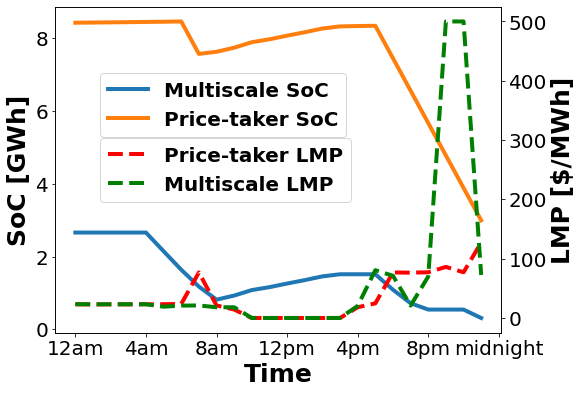

In [38]:
def compare_soc(soc_dl, soc_pt, lmp_dl, lmp_pt, range1, range2):
    x = list(range(0,28,4))
    font1 = {'size': 25, 'weight': 'bold'}
    time_list = ['12am','4am', '8am', '12pm', '4pm', '8pm','midnight']
    fig, ax1 = plt.subplots(figsize = (8,6))
    ax1.plot(soc_dl[range1:range2], label = 'Multiscale SoC', linewidth = 4)
    ax1.plot(soc_pt[range1:range2], label = 'Price-taker SoC', linewidth = 4)
    ax2 = ax1.twinx() 
    ax2.plot(lmp_pt[range1:range2], '--', c = 'r', label = 'Price-taker LMP', linewidth = 4)
    ax2.plot(lmp_dl[range1:range2], '--', c = 'g', label = 'Multiscale LMP', linewidth = 4)
    ax1.set_ylabel('SoC [GWh]', font = font1)
    ax2.set_ylabel('LMP [$/MWh]', font = font1)
    ax1.legend(loc = (0.1,0.6), prop = {'size': 20, 'weight': 'bold'})

    plt.legend(prop = {'size': 20, 'weight': 'bold'}, loc = (0.1,0.4))
    ax1.tick_params(labelsize = 20)
    ax2.tick_params(labelsize = 20)
    ax1.set_xlabel('Time', font = font1)
    ax1.set_xticks(ticks = x, labels = time_list)
#     plt.title('Case 4', font = font1)
    plt.show()
compare_soc(soc_dl, soc_pt, lmp_dl_array, lmp, 432,456)